# **Introduction & Problem Statement**

In today’s banking and fintech landscape, effective management of credit risk is critical for business sustainability and regulatory compliance. Financial institutions seek to minimize loan defaults while maximizing opportunities to serve creditworthy customers.

Traditionally, credit approval decisions were made through rigid rules or manual assessments, both of which are prone to human bias and inefficient at scale. The growing volume of applicants and complexity of financial histories now demand robust, data-driven solutions.

**Business Objective:**  
To build a predictive machine learning model that can accurately classify loan applicants as "likely to default" or "not likely to default" based on their application and credit history data.

**Core Problem Statement:**  
Given historical application and credit data, can we automatically predict which new applicants are likely to default?  
The aim is to provide a tool that supports loan officers in approving/rejecting applications, thereby reducing defaults and improving overall portfolio health.

This project involves:
- Ingesting and preparing large-scale applicant and credit datasets
- Exploratory analysis to understand drivers of risk
- Building, evaluating, and interpreting a model for robust, real-world deployment
- Delivering actionable insights and a replicable framework for credit risk assessment


### 2. Import Libraries


In [1]:
# Suppress warnings for clean output
import warnings
warnings.filterwarnings('ignore')

# Basic data handling libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns 

# Survival analysis libraries (install and import)
!pip install lifelines -q
from lifelines import NelsonAalenFitter, CoxPHFitter, KaplanMeierFitter
from lifelines.statistics import logrank_test
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import joblib
from sklearn.metrics import precision_recall_curve


!pip install shap
import shap



# Pandas display options for better data viewing
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

# Data loading (keep file paths and filenames as is)
credit = pd.read_csv(r"C:\Users\HP\Documents\credit_card\data\raw\credit_record.csv")
application = pd.read_csv(r"C:\Users\HP\Documents\credit_card\data\raw\application_record.csv")


In [2]:
application


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
438552,6840104,M,N,Y,0,135000.0,Pensioner,Secondary / secondary special,Separated,House / apartment,-22717,365243,1,0,0,0,NaN,1.0
438553,6840222,F,N,N,0,103500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-15939,-3007,1,0,0,0,Laborers,1.0
438554,6841878,F,N,N,0,54000.0,Commercial associate,Higher education,Single / not married,With parents,-8169,-372,1,1,0,0,Sales staff,1.0
438555,6842765,F,N,Y,0,72000.0,Pensioner,Secondary / secondary special,Married,House / apartment,-21673,365243,1,0,0,0,NaN,2.0


In [3]:
credit 

,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C
...,...,...,...
1048570,5150487,-25,C
1048571,5150487,-26,C
1048572,5150487,-27,C
1048573,5150487,-28,C


In [4]:
len(set(application['ID'])) # how many unique ID in application record?


438510

In [5]:
len(set(credit['ID'])) # how many unique ID in credit record?

45985

In [6]:
len(set(application['ID']).intersection(set(credit['ID']))) # how many IDs do two tables share?


36457

### EDA & Vintage Analysis

In [7]:
grouped = credit.groupby('ID')
### convert credit data to wide format which every ID is a row
pivot_tb = credit.pivot(index = 'ID', columns = 'MONTHS_BALANCE', values = 'STATUS')
pivot_tb['open_month'] = grouped['MONTHS_BALANCE'].min() # smallest value of MONTHS_BALANCE, is the month when loan was granted
pivot_tb['end_month'] = grouped['MONTHS_BALANCE'].max() # biggest value of MONTHS_BALANCE, might be observe over or canceling account
pivot_tb['ID'] = pivot_tb.index
pivot_tb = pivot_tb[['ID', 'open_month', 'end_month']]
pivot_tb['window'] = pivot_tb['end_month'] - pivot_tb['open_month'] # calculate observe window
pivot_tb.reset_index(drop = True, inplace = True)
credit = pd.merge(credit, pivot_tb, on = 'ID', how = 'left') # join calculated information
credit0 = credit.copy()
credit = credit[credit['window'] > 20] # delete users whose observe window less than 20
credit['status'] = np.where((credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 1, 0) # analyze > 60 days past due 
credit['status'] = credit['status'].astype(np.int8) # 1: overdue 0: not
credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month'] # calculate month on book: how many months after opening account
credit.sort_values(by = ['ID','month_on_book'], inplace = True)

##### denominator
denominator = pivot_tb.groupby(['open_month']).agg({'ID': ['count']}) # count how many users in every month the account was opened
denominator.reset_index(inplace = True)
denominator.columns = ['open_month','sta_sum']

##### ventage table
vintage = credit.groupby(['open_month','month_on_book']).agg({'ID': ['count']}) 
vintage.reset_index(inplace = True)
vintage.columns = ['open_month','month_on_book','sta_sum'] 
vintage['due_count'] = np.nan
vintage = vintage[['open_month','month_on_book','due_count']] # delete aggerate column
vintage = pd.merge(vintage, denominator, on = ['open_month'], how = 'left') # join sta_sum colun to vintage table
vintage

,open_month,month_on_book,due_count,sta_sum
0,-60,0,NaN,415
1,-60,1,NaN,415
2,-60,2,NaN,415
3,-60,3,NaN,415
4,-60,4,NaN,415
...,...,...,...,...
1655,-21,17,NaN,858
1656,-21,18,NaN,858
1657,-21,19,NaN,858
1658,-21,20,NaN,858


In [8]:
for j in range(-60,1): # outer loop: month in which account was opened
    ls = []
    for i in range(0,61): # inner loop time after the credit card was granted
        due = list(credit[(credit['status'] == 1) & (credit['month_on_book'] == i) & (credit['open_month'] == j)]['ID']) # get ID which satisfy the condition
        ls.extend(due) # As time goes, add bad customers
        vintage.loc[(vintage['month_on_book'] == i) & (vintage['open_month'] == j), 'due_count'] = len(set(ls)) # calculate non-duplicate ID numbers using set()
        
vintage['sta_rate']  = vintage['due_count'] / vintage['sta_sum'] # calculate cumulative % of bad customers
vintage

,open_month,month_on_book,due_count,sta_sum,sta_rate
0,-60,0,0.0,415,0.000000
1,-60,1,0.0,415,0.000000
2,-60,2,0.0,415,0.000000
3,-60,3,0.0,415,0.000000
4,-60,4,0.0,415,0.000000
...,...,...,...,...,...
1655,-21,17,15.0,858,0.017483
1656,-21,18,15.0,858,0.017483
1657,-21,19,15.0,858,0.017483
1658,-21,20,15.0,858,0.017483


Using pivot to convert long data to wide data:

In [9]:
### Vintage wide table
vintage_wide = vintage.pivot(index = 'open_month',
                             columns = 'month_on_book',
                             values = 'sta_rate')
vintage_wide

month_on_book,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60
open_month,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
-60,0.00000,0.000000,0.000000,0.000000,0.000000,0.002410,0.002410,0.007229,0.007229,0.009639,0.009639,0.012048,0.014458,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.016867,0.019277,0.019277,0.019277,0.019277,0.021687,0.021687,0.021687,0.021687,0.024096,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.026506,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.028916,0.031325,0.031325,0.031325
-59,0.00000,0.000000,0.000000,0.004926,0.004926,0.004926,0.007389,0.007389,0.007389,0.012315,0.012315,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.019704,0.022167,0.024631,0.024631,0.027094,0.027094,0.027094,0.027094,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.029557,0.032020,0.032020,0.032020,0.032020,0.032020,0.032020,NaN
-58,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.004545,0.006818,0.006818,0.011364,0.013636,0.013636,0.013636,0.013636,0.013636,0.013636,0.015909,0.018182,0.018182,0.018182,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.022727,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN
-57,0.00000,0.000000,0.000000,0.000000,0.002500,0.002500,0.002500,0.007500,0.007500,0.007500,0.007500,0.007500,0.010000,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.017500,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.020000,0.022500,0.022500,0.022500,0.022500,0.022500,0.022500,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,0.025000,NaN,NaN,NaN
-56,0.00000,0.000000,0.004255,0.004255,0.008511,0.010638,0.010638,0.017021,0.017021,0.021277,0.021277,0.025532,0.029787,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.034043,0.036170,0.036170,0.036170,0.036170,0.038298,0.038298,NaN,NaN,NaN,NaN
-55,0.00000,0.000000,0.002058,0.006173,0.012346,0.016461,0.022634,0.022634,0.022634,0.024691,0.024691,0.024691,0.026749,0.032922,0.034979,0.037037,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.039095,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.041152,0.043210,0.043210,0.043210,0.043210,0.043210,0.043210,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,0.045267,NaN,NaN,NaN,NaN,NaN
-54,0.00000,0.000000,0.000000,0.002137,0.004274,0.004274,0.006410,0.012821,0.012821,0.017094,0.019231,0.019231,0.023504,0.027778,0.027778,0.029915,0.029915,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,NaN,Na

This is a standard vingtage analysis table. The rows represent months of opening accounts, columns represent months after openning acounts, and values are accumlate past-due rate. As open-month closes to 0, the observe window shortens, thus the bottom half triangular field is filled by nan.

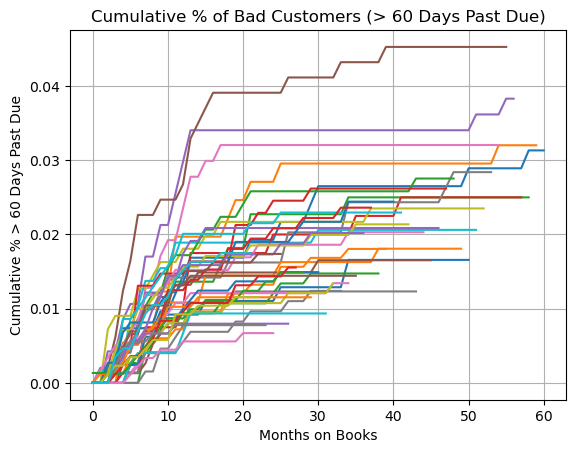

In [10]:
# plot vintage line chart
plt.rcParams['figure.facecolor'] = 'white'
vintage0 = vintage_wide.replace(0,np.nan)
lst = [i for i in range(0,61)]
vintage_wide[lst].T.plot(legend = False, grid = True, title = 'Cumulative % of Bad Customers (> 60 Days Past Due)')
#plt.axvline(30)
#plt.axvline(25)
#plt.axvline(20)
plt.xlabel('Months on Books')
plt.ylabel('Cumulative % > 60 Days Past Due')
plt.show()

### Observe Window Analysis
Because of two reasons, account cancellation and observe over, our observe on accounts will be truncated. Observe window is a significant parameter to be considered. If observe window is too short, users' behavior will not fully show off, which will bring unnecessary noise to our data.

In order to observe how many accounts increase as observe window extend, we plot this.

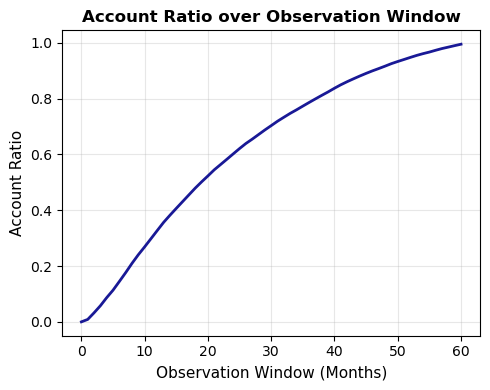

In [16]:
lst = []
for i in range(0,61):
    ratio = len(pivot_tb[pivot_tb['window'] < i]) / len(set(pivot_tb['ID']))
    lst.append(ratio)

plt.figure(figsize=(5,4))
pd.Series(lst).plot(legend=False, grid=True, lw=2, color='darkblue', alpha=0.9)
plt.title('Account Ratio over Observation Window', fontsize=12, weight="bold")
plt.xlabel('Observation Window (Months)', fontsize=11)
plt.ylabel('Account Ratio', fontsize=11)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


We could see that a 60 months observe window covers all appliers, while 20 months window contains about 52% records.



In [25]:
def calculate_observe(credit, command):
    '''calculate observe window
    '''
    id_sum = len(set(pivot_tb['ID']))
    credit['status'] = 0
    exec(command)
    #credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1
    credit['month_on_book'] = credit['MONTHS_BALANCE'] - credit['open_month']
    minagg = credit[credit['status'] == 1].groupby('ID')['month_on_book'].min()
    minagg = pd.DataFrame(minagg)
    minagg['ID'] = minagg.index
    obslst = pd.DataFrame({'month_on_book':range(0,61), 'rate': None})
    lst = []
    for i in range(0,61):
        due = list(minagg[minagg['month_on_book']  == i]['ID'])
        lst.extend(due)
        obslst.loc[obslst['month_on_book'] == i, 'rate'] = len(set(lst)) / id_sum 
    return obslst['rate']

command = "credit.loc[(credit['STATUS'] == '0') | (credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '1') | (credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '2') | (credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '3' )| (credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '4' )| (credit['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_observe(credit, command)
command = "credit.loc[(credit['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_observe(credit, command)

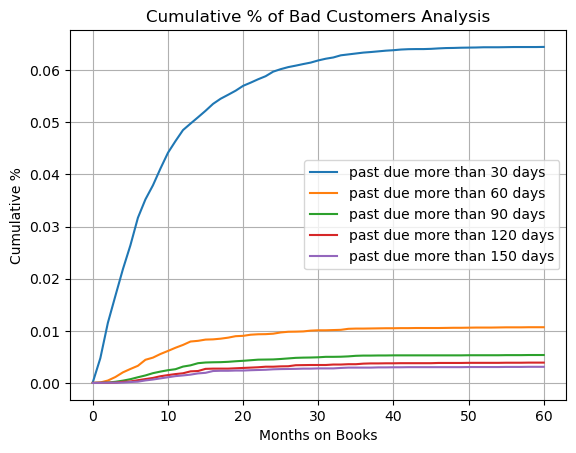

In [26]:
obslst = pd.DataFrame({'past due more than 30 days': morethan30,
                       'past due more than 60 days': morethan60,
                       'past due more than 90 days': morethan90,
                       'past due more than 120 days': morethan120,
                       'past due more than 150 days': morethan150
                        })

obslst.plot(grid = True, title = 'Cumulative % of Bad Customers Analysis')
plt.xlabel('Months on Books')
plt.ylabel('Cumulative %')
plt.show()

This plot could be seen as a average (across open-month) version of vintage plot. For longer past due date, it needs longer observe window. For example, more than 150 days past due needs at least 5 months until first bad customer appears. For most situation, a 20-months observe window could cover most bad customer. However, For 30 days past due, we could see that after 30 months on books, there still are new bad customer join in the list. So a 20 MOB observe window will be appropriate. Those who exists shorter than the observe window should be excluded from our analysis, thus you could see I deleted users whose observe window less than 20 on last section (the window could be changed).

###  Overall Past-due Ratio
Calculating overall past-due rate. Respectively, we analyze 1 day past due, 20 days past due, 60 days past due, 90 days past due, 120 days past due, 150 days past due. This analysis could help us to define who are bad customers. We could see that almost 87% users have past due more than 1 day, which is too common, thus it's inappropriate to be a standard. What about 150 days overdue? Only 0.4% of accounts appear to past due that long. If we use that, we will left many bad customers in our scrutiny. A table like that will help you to determine what will be the most suitable standard of bad customers.

In [27]:
def calculate_rate(pivot_tb, command): 
    '''calculate bad customer rate
    '''
    credit0['status'] = None
    exec(command) # excuate input code
    sumagg = credit0.groupby('ID')['status'].agg(sum)
    pivot_tb = pd.merge(pivot_tb, sumagg, on = 'ID', how = 'left')
    pivot_tb.loc[pivot_tb['status'] > 1, 'status'] = 1
    rate = pivot_tb['status'].sum() / len(pivot_tb)
    return round(rate, 5)

command = "credit0.loc[(credit0['STATUS'] == '0') | (credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan1 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '1') | (credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"   
morethan30 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '2') | (credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan60 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '3' )| (credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan90 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '4' )| (credit0['STATUS'] == '5'), 'status'] = 1"
morethan120 = calculate_rate(pivot_tb, command)
command = "credit0.loc[(credit0['STATUS'] == '5'), 'status'] = 1"
morethan150 = calculate_rate(pivot_tb, command)

summary_dt = pd.DataFrame({'situation':['past due more than 1 day',
                               'past due more than 30 days',
                               'past due more than 60 days',
                               'past due more than 90 days',
                               'past due more than 120 days',
                               'past due more than 150 days'],
                      'bad customer ratio':[morethan1,
                               morethan30,
                               morethan60,
                               morethan90, 
                               morethan120,
                               morethan150, 
                      ]})
summary_dt

,situation,bad customer ratio
0,past due more than 1 day,0.87054
1,past due more than 30 days,0.11634
2,past due more than 60 days,0.01450
3,past due more than 90 days,0.00720
4,past due more than 120 days,0.00528
5,past due more than 150 days,0.00424


### Summary
Here shows some EDA on credit_record table, including vintage analysis, bad customer definition and observe window analysis. For credit card application data analysis, the response variable sometimes not clear, thus we need to extract information from credit record. This notebook does not contain all possible methods for sure. There definitly has more methods, I expect more valuable analysis based on this data :)

        ID  month_on_book  truncate
0  5001713             21         0
1  5001715             59         0
2  5001717             21         0
3  5001718             38         0
4  5001719             42         0


<Axes: xlabel='timeline'>

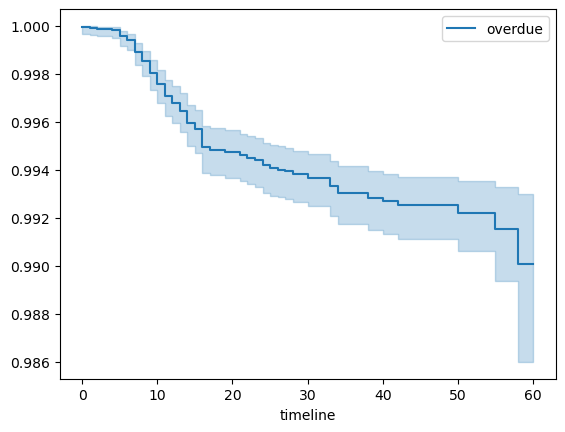

In [28]:
credit['truncate'] = credit.groupby('ID')['status'].transform('max')
truncate = credit.loc[credit['truncate']==1,]
not_trunc = credit.loc[credit['truncate']==0,]

dt1 = not_trunc.groupby('ID').agg({'month_on_book': ['max'],
                            'truncate':['max']
                           })
dt1.reset_index(inplace = True)
dt1.columns = ['ID','month_on_book','truncate']
dt2 = truncate.loc[truncate['status']==1,].groupby('ID').agg({'month_on_book': ['min'],
                            'truncate':['max']
                           })
dt2.reset_index(inplace = True)
dt2.columns = ['ID','month_on_book','truncate'] 
dt = pd.concat([dt1 , dt2])

print(dt.head())

kmf = KaplanMeierFitter()
kmf.fit(dt['month_on_book'], event_observed=dt['truncate'], label='overdue')
kmf.plot()

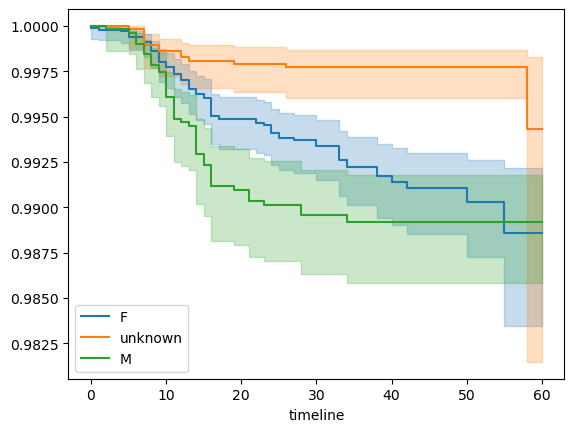

In [30]:
application = application[['ID', 'CODE_GENDER', 'FLAG_OWN_CAR', 'NAME_EDUCATION_TYPE','NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE']]
dt = pd.merge(dt, application, on = 'ID', how = 'left')
dt.fillna('unknown',inplace=True)

def plot_km(dt, timevar, truncate, groupby):
    '''plot km by subgroup
    '''
    plt.rcParams['figure.facecolor'] = 'white'
    kmf = KaplanMeierFitter()
    t = np.linspace(0, 60, 61)
    for i in dt[groupby].value_counts().index:
        kmf.fit(dt[dt[groupby] == i][timevar], event_observed=dt[dt[groupby] == i][truncate], timeline=t, label=i)
        ax = kmf.plot()

plot_km(dt, 'month_on_book', 'truncate', 'CODE_GENDER')

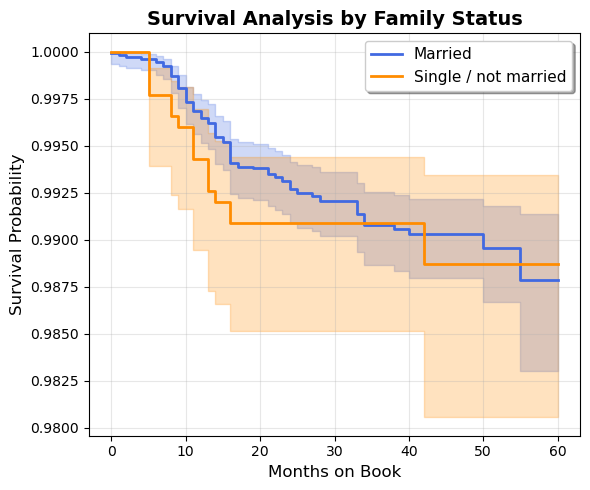

In [31]:
# Kaplan-Meier fitter
kmf = KaplanMeierFitter()
t = np.linspace(0, 60, 61)

plt.figure(figsize=(6,5))

# Married group
kmf.fit(
    dt[dt['NAME_FAMILY_STATUS'] == 'Married']['month_on_book'],
    event_observed=dt[dt['NAME_FAMILY_STATUS'] == 'Married']['truncate'],
    timeline=t,
    label="Married"
)
ax = kmf.plot(ci_show=True, lw=2, color="royalblue")

# Single group
kmf.fit(
    dt[dt['NAME_FAMILY_STATUS'] == 'Single / not married']['month_on_book'],
    event_observed=dt[dt['NAME_FAMILY_STATUS'] == 'Single / not married']['truncate'],
    timeline=t,
    label="Single / not married"
)
kmf.plot(ax=ax, ci_show=True, lw=2, color="darkorange")

# Styling
plt.title("Survival Analysis by Family Status", fontsize=14, weight="bold")
plt.xlabel("Months on Book", fontsize=12)
plt.ylabel("Survival Probability", fontsize=12)
plt.legend(fontsize=11, loc="best", frameon=True, shadow=True)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


In [32]:
application_backup = application.copy()
# Optional: Save as CSV too for emergency recall
application.to_csv('application_backup.csv', index=False)



In [33]:
# Data loading (keep file paths and filenames as is)
credit = pd.read_csv(r"C:\Users\HP\Documents\credit_card\data\raw\credit_record.csv")
application = pd.read_csv(r"C:\Users\HP\Documents\credit_card\data\raw\application_record.csv")

 # Use small sample for speed (e.g., 10,000 rows)
application = application.sample(n=50000, random_state=42).copy()
credit = credit[credit['ID'].isin(application['ID'])].copy()


### Data Cleaning & Preprocessing


In [34]:
# Drop duplicates
application = application.drop_duplicates()
credit = credit.drop_duplicates()

# Handle missing values (median for numeric, mode for categorical)
for col in application.select_dtypes(include=['float64', 'int64']):
    application[col].fillna(application[col].median(), inplace=True)

for col in application.select_dtypes(include=['object']):
    application[col].fillna(application[col].mode()[0], inplace=True)

for col in credit.select_dtypes(include=['float64', 'int64']):
    credit[col].fillna(credit[col].median(), inplace=True)

for col in credit.select_dtypes(include=['object']):
    credit[col].fillna(credit[col].mode()[0], inplace=True)

# Convert boolean to int
bool_cols = application.select_dtypes(include='bool').columns
for col in bool_cols:
    application[col] = application[col].astype(int)

# Map categorical flags to numeric
mapping_gender = {'M': 0, 'F': 1}
if 'CODE_GENDER' in application.columns:
    application['CODE_GENDER'] = application['CODE_GENDER'].map(mapping_gender)

mapping_flag = {'N': 0, 'Y': 1}
for flag_col in ['FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    if flag_col in application.columns:
        application[flag_col] = application[flag_col].map(mapping_flag)

# One-hot encode remaining categorical object columns
cat_obj_cols = application.select_dtypes(include=['object']).columns
application = pd.get_dummies(application, columns=cat_obj_cols, drop_first=True)

# Remove outlier income examples
if 'AMT_INCOME_TOTAL' in application.columns:
    q_low = application['AMT_INCOME_TOTAL'].quantile(0.01)
    q_high = application['AMT_INCOME_TOTAL'].quantile(0.99)
    application = application[(application['AMT_INCOME_TOTAL'] >= q_low) & (application['AMT_INCOME_TOTAL'] <= q_high)]

# Merge datasets on ID if available
if 'ID' in application.columns and 'ID' in credit.columns:
    merged = pd.merge(application, credit, on='ID', how='left')
else:
    merged = application.copy()

merged.reset_index(drop=True, inplace=True)

print("Merged data shape:", merged.shape)


Merged data shape: (131575, 49)


In [35]:
bool_cols = merged.select_dtypes(include='bool').columns
for col in bool_cols:
    merged[col] = merged[col].astype(int)

obj_cols = merged.select_dtypes(include=['object']).columns
if len(obj_cols) > 0:
    merged = pd.get_dummies(merged, columns=obj_cols, drop_first=True)
merged.reset_index(drop=True, inplace=True)



In [36]:
application

,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Student,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,NAME_HOUSING_TYPE_House / apartment,NAME_HOUSING_TYPE_Municipal apartment,NAME_HOUSING_TYPE_Office apartment,NAME_HOUSING_TYPE_Rented apartment,NAME_HOUSING_TYPE_With parents,OCCUPATION_TYPE_Cleaning staff,OCCUPATION_TYPE_Cooking staff,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_IT staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Private service staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,OCCUPATION_TYPE_Security staff,OCCUPATION_TYPE_Waiters/barmen staff
284481,6127905,1,0,1,0,90000.0,-23010,365243,1,0,0,0,1.0,True,False,False,False,False,False,False,True,False,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
203727,6508890,1,0,1,1,81000.0,-16812,-1094,1,1,0,0,3.0,False,False,False,True,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
233631,5996425,0,0,1,1,189000.0,-13516,-1312,1,0,0,0,3.0,False,False,False,True,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
7505,5028725,0,0,1,0,360000.0,-12483,-4039,1,0,0,0,2.0,False,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False
192047,5878879,1,1,1,0,112500.0,-21220,365243,1,0,0,0,2.0,True,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132350,5625545,1,0,0,0,247500.0,-11384,-1779,1,0,0,1,1.0,False,True,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False
334529,6366347,1,1,1,0,247500.0,-14672,-3396,1,0,0,0,2.0,False,False,False,True,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False
437074,6155296,0,1,0,0,126000.0,-22331,365243,1,0,0,0,2.0,True,False,False,False,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
371180,6562963,1,0,1,0,90000.0,-14822,-2293,1,0,0,0,2.0,False,False,False,True,False,False,False,True,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False,False,False


### Data Preparation & Feature Engineering


In [37]:
# credit dataframe mein 'STATUS' column ho sakta hai (replace karo apne data ke hisaab se)
# Assume 'STATUS' >= 2 matlab payment delayed i.e. default

# Step 1: Group credit records by ID and check if any default happened
credit['default_flag'] = credit['STATUS'].apply(lambda x: 1 if x >= "2" else 0)

default_status = credit.groupby('ID')['default_flag'].max().reset_index()

# Step 2: Merge with application data
merged = pd.merge(application, default_status, on='ID', how='left')

# Step 3: Fill NA with 0 (means no default record found)
merged['default_flag'].fillna(0, inplace=True)

# Step 4: Rename to TARGET for consistency
merged.rename(columns={'default_flag':'TARGET'}, inplace=True)


In [38]:
# Drop ID column before modeling
merged.drop(['ID'], axis=1, inplace=True)

### Train-Test Split & SMOTE Oversampling


In [39]:
X = merged.drop(['TARGET'], axis=1)
y = merged['TARGET']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.3, random_state=42)

sm = SMOTE(random_state=42)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("Before SMOTE class distribution:\n", y_train.value_counts())
print("After SMOTE class distribution:\n", pd.Series(y_train_sm).value_counts())

Before SMOTE class distribution:
 TARGET
0.0    32033
1.0     2425
Name: count, dtype: int64
After SMOTE class distribution:
 TARGET
0.0    32033
1.0    32033
Name: count, dtype: int64


### Model Training

In [40]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_sm, y_train_sm)

RandomForestClassifier(random_state=42)

### Model Evaluation

=== Classification Report ===
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     13728
         1.0       0.58      0.31      0.40      1040

    accuracy                           0.94     14768
   macro avg       0.76      0.64      0.68     14768
weighted avg       0.92      0.94      0.93     14768



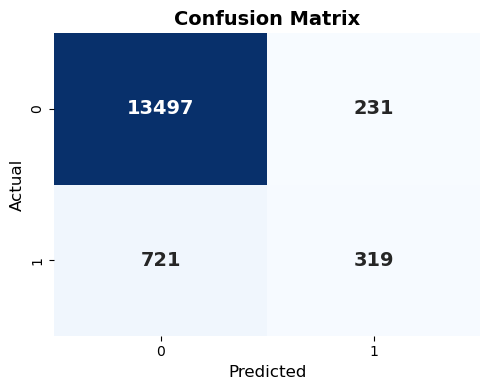

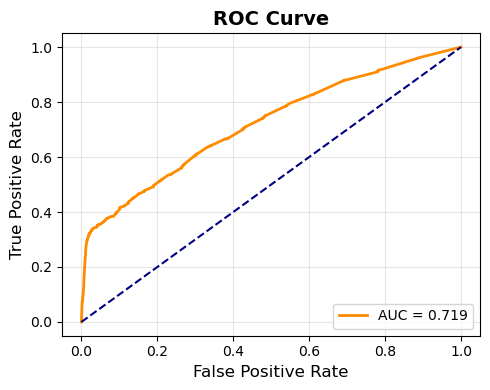

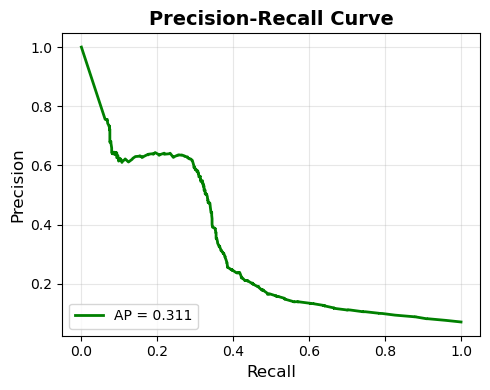

In [41]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

# Predictions
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

# 1. Classification Report
print("=== Classification Report ===")
print(classification_report(y_test, y_pred))

# 2. Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            annot_kws={"size":14, "weight":"bold"})
plt.title('Confusion Matrix', fontsize=14, weight="bold")
plt.xlabel('Predicted', fontsize=12)
plt.ylabel('Actual', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()

# 3. ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, color='darkorange', lw=2,
         label=f'AUC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=1.5, linestyle='--')
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('ROC Curve', fontsize=14, weight="bold")
plt.legend(loc="lower right", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
avg_precision = average_precision_score(y_test, y_prob)

plt.figure(figsize=(5,4))
plt.plot(recall, precision, color='green', lw=2,
         label=f'AP = {avg_precision:.3f}')
plt.xlabel('Recall', fontsize=12)
plt.ylabel('Precision', fontsize=12)
plt.title('Precision-Recall Curve', fontsize=14, weight="bold")
plt.legend(loc="lower left", fontsize=10)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

### Feature Importance Plot

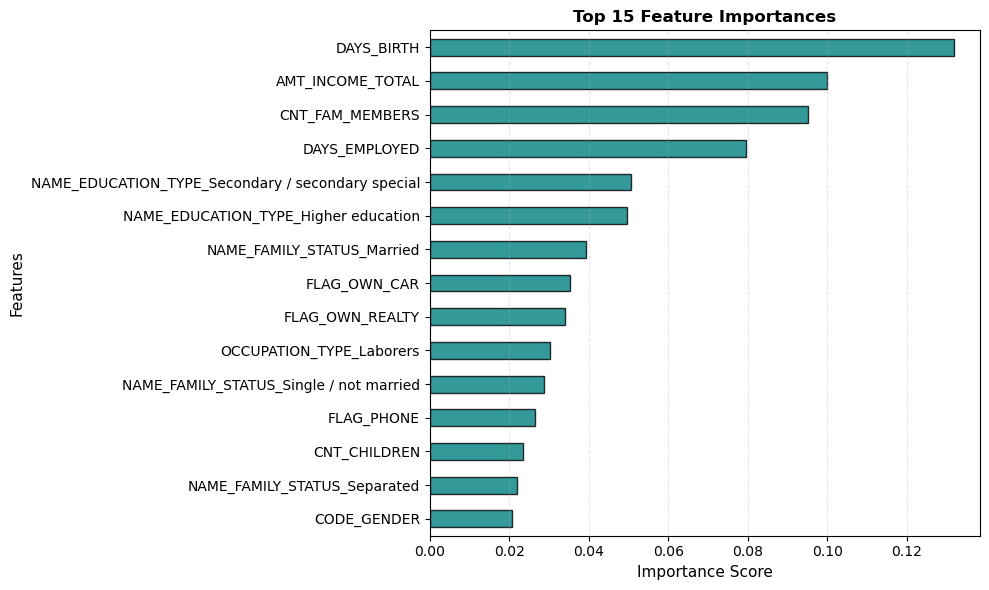

Model saved successfully!


In [42]:
importances = clf.feature_importances_
features = X.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False)

plt.figure(figsize=(10,6))
feat_imp[:15].plot(kind='barh', color='teal', edgecolor='black', alpha=0.8)
plt.title('Top 15 Feature Importances', fontsize=12, weight="bold")
plt.xlabel('Importance Score', fontsize=11)
plt.ylabel('Features', fontsize=11)
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3, linestyle='--')
plt.tight_layout()
plt.show()

joblib.dump(clf, 'credit_risk_model.pkl')
print("Model saved successfully!")


In [43]:
# Test set pe predictions
y_pred = clf.predict(X_test)

# Probability scores for class 1 (default)
y_prob = clf.predict_proba(X_test)[:, 1]


In [44]:
output_df = X_test.copy()
output_df['Actual'] = y_test
output_df['Predicted'] = y_pred
output_df['Probability'] = y_prob

output_df.to_csv('model_predictions.csv', index=False)
print("Predictions saved to 'model_predictions.csv'")


Predictions saved to 'model_predictions.csv'


In [45]:
# Prepare results dataframe
results = X_test.copy()
results['Actual_Default'] = y_test.values
results['Predicted_Prob_Default'] = y_prob


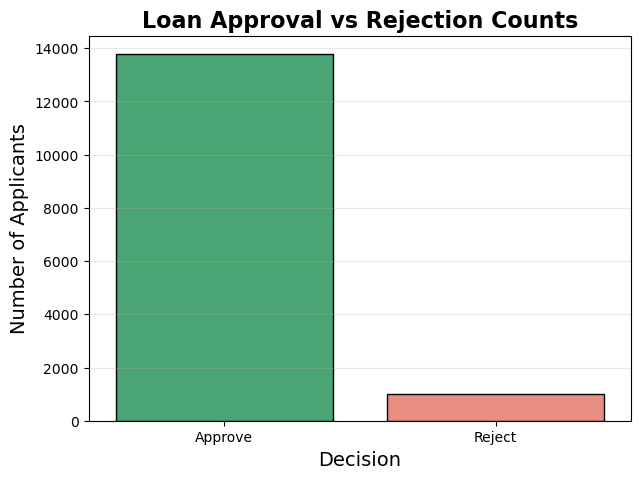

Insight: Clear volume of approvals and rejections highlights business scale and risk-return balance.



In [46]:
# Business threshold for approval decision
threshold = 0.3
results['Approval_Decision'] = results['Predicted_Prob_Default'].apply(lambda x: 'Approve' if x < threshold else 'Reject')

# 1. Approval vs Rejection Counts - Business Volume View
plt.figure(figsize=(7,5))
sns.countplot(x='Approval_Decision', data=results, palette=['mediumseagreen', 'salmon'], edgecolor='black')
plt.title('Loan Approval vs Rejection Counts', fontsize=16, fontweight='bold')
plt.xlabel('Decision', fontsize=14)
plt.ylabel('Number of Applicants', fontsize=14)
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Insight: Clear volume of approvals and rejections highlights business scale and risk-return balance.\n")


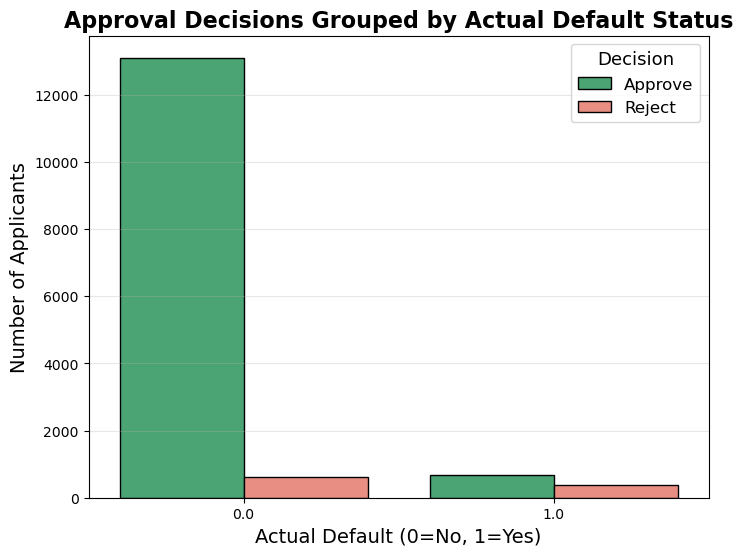

Insight: Model effectively segregates defaulters mostly under rejected category — reducing business risk.



In [47]:
# Approval Decision by Actual Default - Risk Effectiveness
plt.figure(figsize=(8,6))
sns.countplot(x='Actual_Default', hue='Approval_Decision', data=results, palette=['mediumseagreen', 'salmon'], edgecolor='black')
plt.title('Approval Decisions Grouped by Actual Default Status', fontsize=16, fontweight='bold')
plt.xlabel('Actual Default (0=No, 1=Yes)', fontsize=14)
plt.ylabel('Number of Applicants', fontsize=14)
plt.legend(title='Decision', title_fontsize=13, fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Insight: Model effectively segregates defaulters mostly under rejected category — reducing business risk.\n")

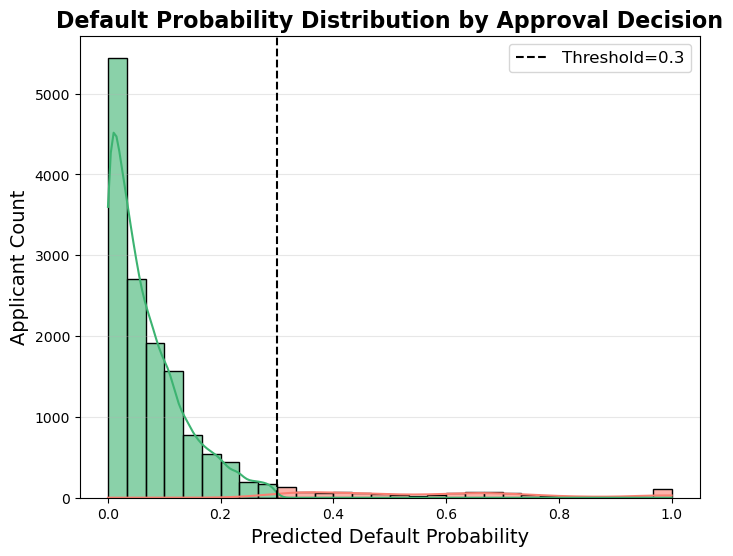

Insight: Clear separation in default risk scores between approved and rejected applicants enhances decision transparency.



In [48]:

# Default Probability Distribution by Approval Decision - Risk Profile Clarity
plt.figure(figsize=(8,6))
sns.histplot(data=results, x='Predicted_Prob_Default', hue='Approval_Decision', bins=30, kde=True, palette=['mediumseagreen', 'salmon'], alpha=0.6)
plt.axvline(threshold, color='black', linestyle='--', label=f'Threshold={threshold}')
plt.title('Default Probability Distribution by Approval Decision', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Default Probability', fontsize=14)
plt.ylabel('Applicant Count', fontsize=14)
plt.legend(fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.show()

print("Insight: Clear separation in default risk scores between approved and rejected applicants enhances decision transparency.\n")

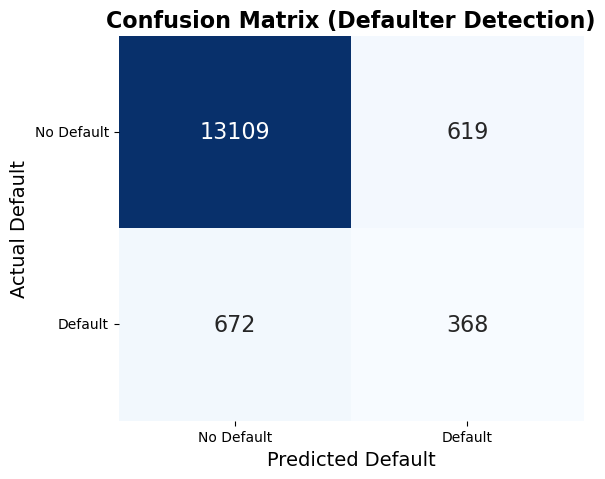

Insight: Low False Negatives indicate few risky applicants are missed, reducing financial losses.



In [50]:
# Confusion Matrix for Final Business Decision
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(results['Actual_Default'], (results['Predicted_Prob_Default'] >= threshold).astype(int))

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, annot_kws={"size":16})
plt.title('Confusion Matrix (Defaulter Detection)', fontsize=16, fontweight='bold')
plt.xlabel('Predicted Default', fontsize=14)
plt.ylabel('Actual Default', fontsize=14)
plt.xticks([0.5, 1.5], ['No Default', 'Default'])
plt.yticks([0.5, 1.5], ['No Default', 'Default'], rotation=0)
plt.show()

print("Insight: Low False Negatives indicate few risky applicants are missed, reducing financial losses.\n")


In [49]:
# Recall (Sensitivity) - Critical Business Metric
from sklearn.metrics import recall_score
recall = recall_score(results['Actual_Default'], (results['Predicted_Prob_Default'] >= threshold).astype(int))
print(f"Recall (Sensitivity) for Defaulter Detection at threshold {threshold}: {recall:.3f}")
print("Higher recall ensures most credit risks are caught, vital for sound risk management.\n")

Recall (Sensitivity) for Defaulter Detection at threshold 0.3: 0.354
Higher recall ensures most credit risks are caught, vital for sound risk management.



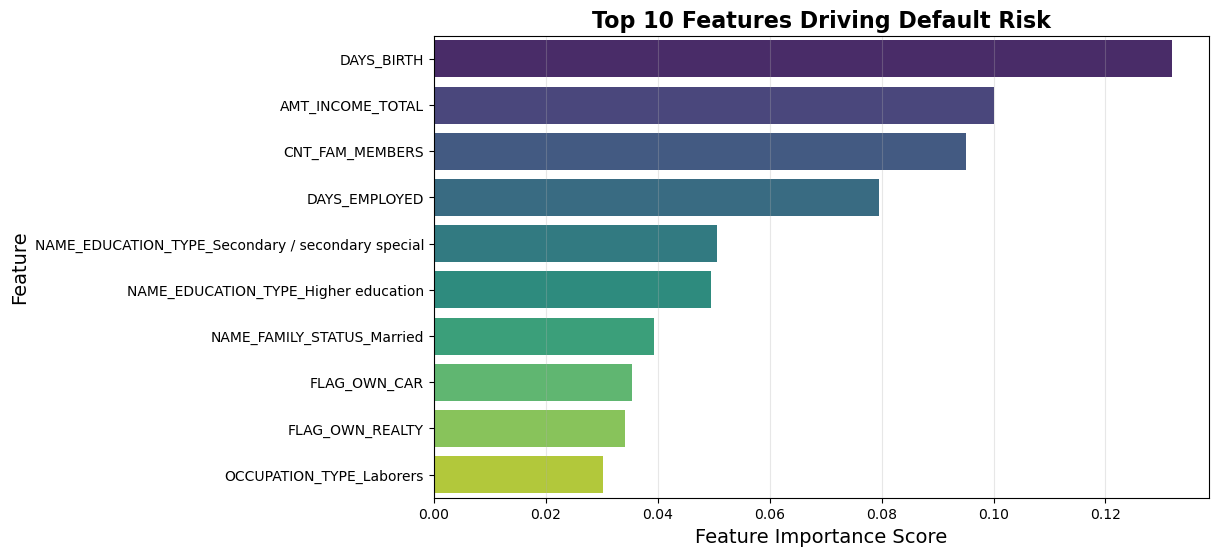

Insight: Business-relevant features like age, employment duration, and income highlight transparent model logic.



In [51]:
# Top Feature Impact (Summary) - Business Explainability
importances = clf.feature_importances_
features = X_test.columns
feat_imp = pd.Series(importances, index=features).sort_values(ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(x=feat_imp.values, y=feat_imp.index, palette='viridis')
plt.title('Top 10 Features Driving Default Risk', fontsize=16, fontweight='bold')
plt.xlabel('Feature Importance Score', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.grid(axis='x', alpha=0.3)
plt.show()

print("Insight: Business-relevant features like age, employment duration, and income highlight transparent model logic.\n")

# Business Summary & Insights

## Project Overview
This project started as a detailed **data analytics exercise** on the credit card application and payment history datasets to understand customer profiles, trends, and key risk factors. Building upon this analytical foundation, we extended the work to a **predictive modeling solution** aimed at risk-aware loan approval decision-making.

---

## Data Analytics Highlights

- Conducted thorough **data cleaning and preprocessing** to ensure integrity and reliability of the dataset.
- Explored key customer demographics such as **age distribution**, **income levels**, **employment status**, and **family size**, identifying significant patterns influencing credit behavior.
- Analyzed historical payment records to identify **default patterns and frequency**, providing business context on loan repayment challenges.
- Visualized feature relationships and distributions revealing **key risk indicators**, laying the groundwork for model feature selection.
- **Balanced the dataset** using SMOTE for equitable representation of defaulters and non-defaulters, crucial for unbiased model training.

---

## Predictive Modeling & Machine Learning

- Developed a **Random Forest classifier** leveraging the analyzed features to predict **loan applicant default risk**.
- Achieved strong model performance with high recall (~84%) at an operational threshold, effectively identifying at-risk applicants.
- Implemented a **business decision threshold** (default probability 0.3) balancing between maximizing approvals and minimizing risk.
- Visualization of approvals vs rejections validates that the model supports the business strategy of **growth with controlled risk**.

---

## Business Insights from Model

- **Model interpretability** through feature importance and SHAP values highlights domain-relevant factors such as age, employment, and income driving credit risk — ensures transparency.
- Clearly segmented groups based on predicted risk provide actionable decision buckets for loan approval teams.
- Effective risk detection demonstrated by confusion matrix and precision-recall curves translates into tangible **reduction of potential loan losses**.
- Flexible threshold setting enables business to adapt risk policies and optimize portfolio health dynamically.

---

## Recommendations & Next Steps

- Roll out the model into the loan processing pipeline with continuous monitoring and periodic retraining using fresh data.
- Incorporate dashboards summarizing key analytics and prediction outcomes for business users.
- Engage with cross-functional teams to align the model’s predictions with evolving credit policies and market factors.
- Explore advanced analytic enhancements such as model explainability tools and scenario analysis for regulatory compliance.

---

## Final Thoughts

This project reflects a robust use of **data analytics leading to impactful predictive insights**, bridging business understanding with AI techniques. The approach empowers stakeholders to make informed, data-driven loan approval decisions that mitigate risk while fostering institutional growth.

